In [1]:
import os
os.environ["CUDA_DEVICE_ORDER"]="PCI_BUS_ID"   # see issue #152
os.environ["CUDA_VISIBLE_DEVICES"]="0"

In [2]:
from IPython import get_ipython
%load_ext autoreload
%autoreload 2

from IPython.core.interactiveshell import InteractiveShell
InteractiveShell.ast_node_interactivity = 'all'  #'last', 'last_expr'

In [3]:
import sys
sys.path.insert(0, '/home/hushengchun/python_library/TransformerLens/')
from argparse import ArgumentParser
from functools import partial 
from pathlib import Path

import pandas as pd
import numpy as np
import torch
from transformer_lens import HookedTransformer
import matplotlib.pyplot as plt
from tqdm import tqdm

from eap.graph import Graph
from eap.attribute import attribute
from eap.evaluate import evaluate_graph, evaluate_baseline

from dataset import EAPDataset
from metrics import get_metric

In [4]:
from transformers import AutoModelForCausalLM

In [5]:
cache_dir = '/home/xd/.cache/torch/transformers/'
proxies = {'http': '192.168.53.250:10801'}

#model_name = 'EleutherAI/pythia-2.8b'
model_name = 'gpt2'
device = 0

model = AutoModelForCausalLM.from_pretrained(model_name, cache_dir=cache_dir, proxies=proxies,
    local_files_only=False, low_cpu_mem_usage=True, use_safetensors=False).to(device, dtype=torch.float16)

In huggingface_hub.file_download.cached_download: url = https://huggingface.co/gpt2/resolve/main/pytorch_model.bin
in cached_download: link_path = /home/xd/.cache/torch/transformers/gpt2-pytorch_model.bin
In PreTrainedModel.from_pretrained: resolved_archive_file, filename = /home/xd/.cache/torch/transformers/gpt2-pytorch_model.bin pytorch_model.bin
In huggingface_hub.file_download.cached_download: url = https://huggingface.co/gpt2/resolve/main/generation_config.json
in cached_download: link_path = /home/xd/.cache/torch/transformers/generation_config.json


In [6]:
model = HookedTransformer.from_pretrained(model_name,center_writing_weights=False,
    center_unembed=False,
    fold_ln=False,
    device='cuda',
    hf_model=model,
)

Loaded pretrained model gpt2 into HookedTransformer


In [7]:
task = 'ioi'

In [16]:
model.cfg.use_split_qkv_input = True
model.cfg.use_attn_result = True
model.cfg.use_hook_mlp_in = True
task_metric_name = 'logit_diff'
ds = EAPDataset(task, model_name, filename="gpt2_1.csv")
batch_size = 20
dataloader = ds.to_dataloader(batch_size)
task_metric = get_metric(task_metric_name, task, model=model)

In [11]:
import time

In [17]:
model_name_noslash = model_name.split('/')[-1]

T1 = time.time()
g2 = Graph.from_model(model)
attribute(model, g2, dataloader, partial(task_metric, mean=True, loss=True), method='EAP-IG', ig_steps=5)

T2 = time.time()

print('运行时间：%s s' %(T2 - T1))

100%|██████████| 32491/32491 [00:00<00:00, 501730.88it/s]

运行时间：3.4634268283843994 s


In [19]:
g2.apply_greedy(300)
g2.prune_dead_nodes()
gs2 = g2.to_graphviz()
gs2.draw(f'gpt2_1-ioi.png', prog='dot')

In [20]:
dataloader = tqdm(dataloader)
dataloader = list(dataloader)

100%|██████████| 5/5 [00:00<00:00, 287.64it/s]


In [23]:
layer, head = [(2, 2), (4, 11)][1]

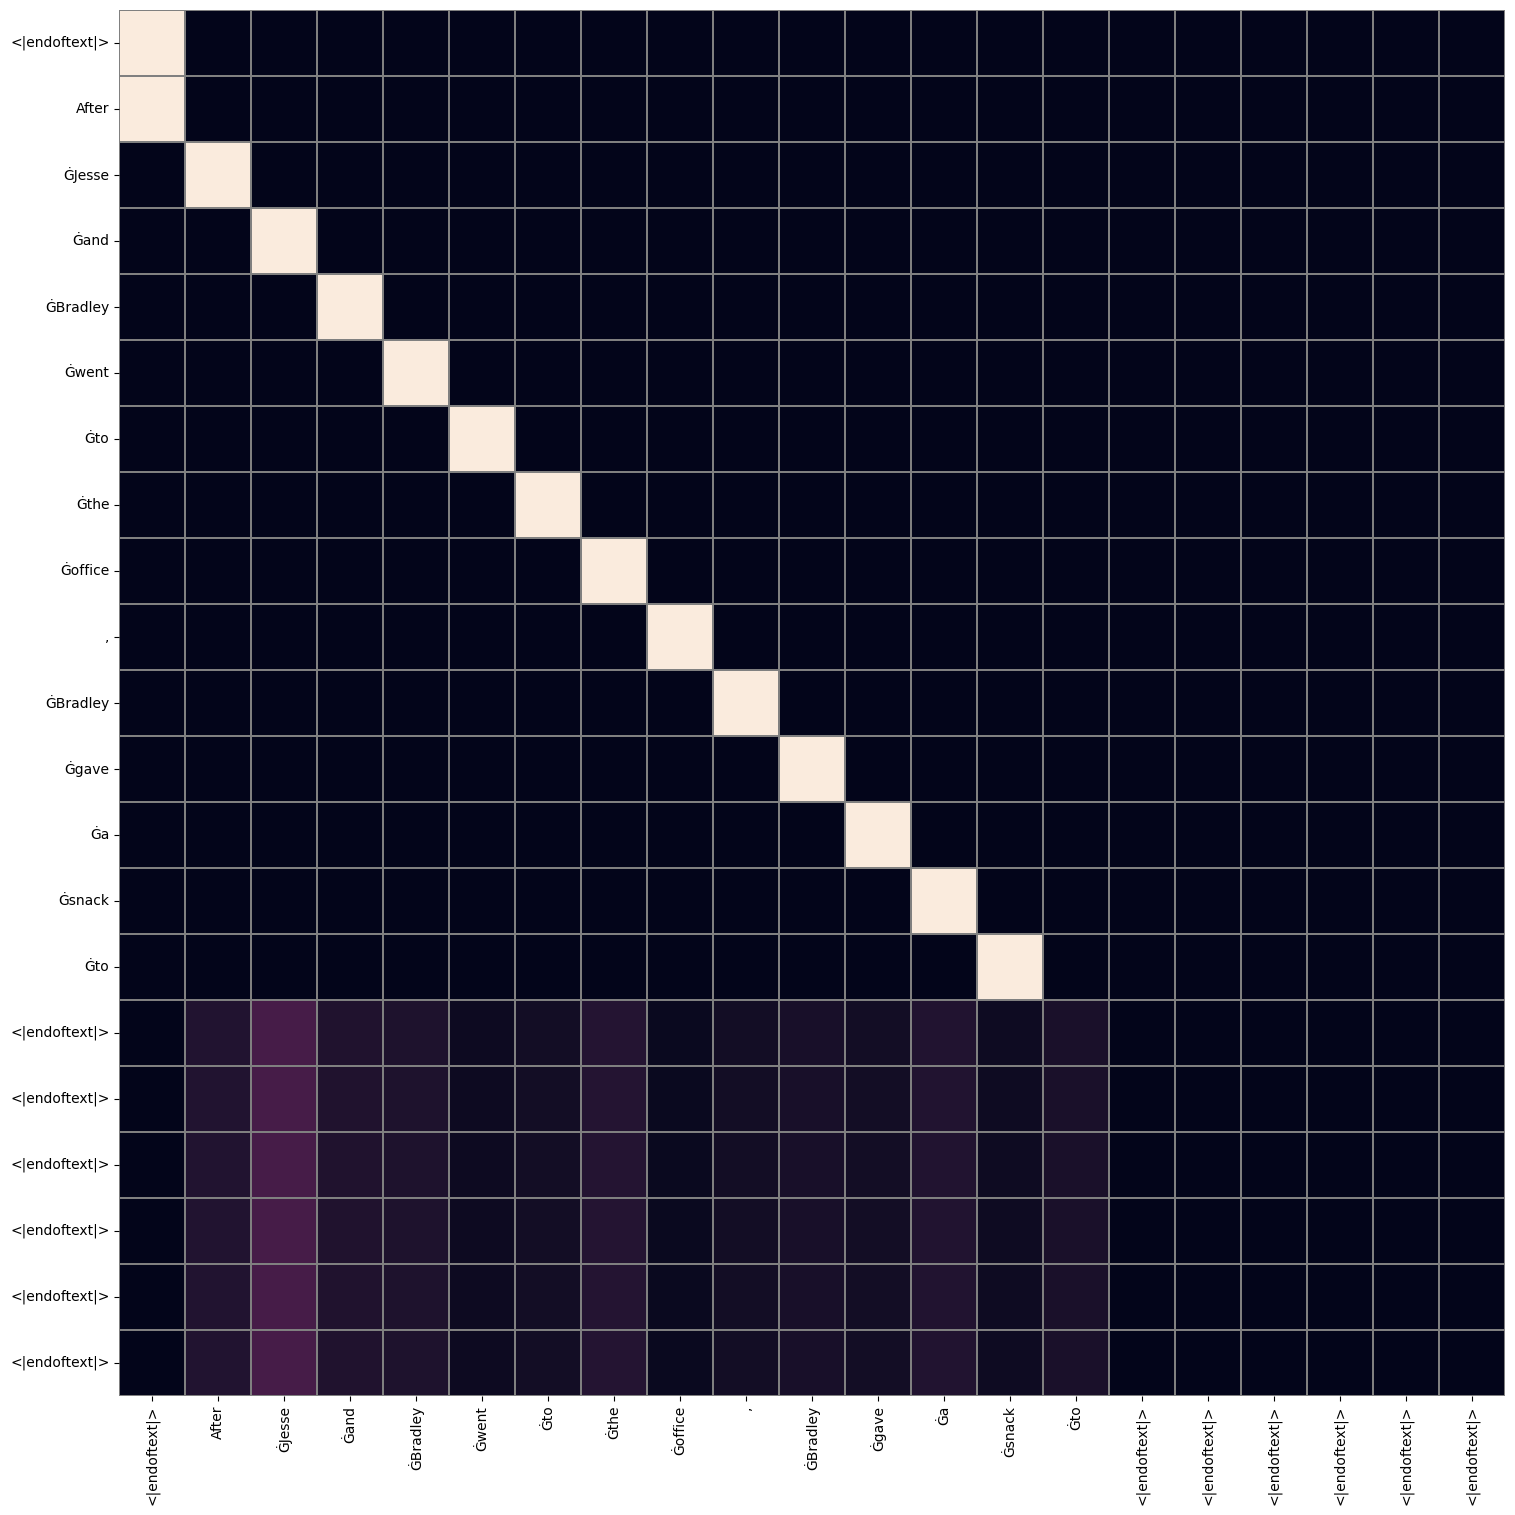

In [24]:
from eap.attribute import tokenize_plus, _plot_attn
for clean, corrupt, label in dataloader[0:1]:
    # tokens_ids = model.to_tokens(clean, prepend_bos=True, padding_side='right')
    token_ids, attention_mask, input_lengths, n_pos = tokenize_plus(model, clean)
    clean_logits, cache = model.run_with_cache(token_ids, attention_mask = attention_mask)
    tokens = model.tokenizer.convert_ids_to_tokens(token_ids[0])
    attn = cache[f'blocks.{layer}.attn.hook_pattern'][0][head]
    _plot_attn(attn, tokens, figsize=(18, 18))

In [13]:
model

HookedTransformer(
  (embed): Embed()
  (hook_embed): HookPoint()
  (pos_embed): PosEmbed()
  (hook_pos_embed): HookPoint()
  (blocks): ModuleList(
    (0-11): 12 x TransformerBlock(
      (ln1): LayerNorm(
        (hook_scale): HookPoint()
        (hook_normalized): HookPoint()
      )
      (ln2): LayerNorm(
        (hook_scale): HookPoint()
        (hook_normalized): HookPoint()
      )
      (attn): Attention(
        (hook_k): HookPoint()
        (hook_q): HookPoint()
        (hook_v): HookPoint()
        (hook_z): HookPoint()
        (hook_attn_scores): HookPoint()
        (hook_pattern): HookPoint()
        (hook_result): HookPoint()
      )
      (mlp): MLP(
        (hook_pre): HookPoint()
        (hook_post): HookPoint()
      )
      (hook_attn_in): HookPoint()
      (hook_q_input): HookPoint()
      (hook_k_input): HookPoint()
      (hook_v_input): HookPoint()
      (hook_mlp_in): HookPoint()
      (hook_attn_out): HookPoint()
      (hook_mlp_out): HookPoint()
      (hook_re